# Import modules

In [2]:
import os
import cv2
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout

2024-04-09 22:51:14.666978: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 22:51:14.693648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 22:51:14.693674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 22:51:14.694355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 22:51:14.698468: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 22:51:14.699271: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Check Metadata

In [3]:
data_path = "./Dino-Data"
os.chdir(data_path)
video = cv2.VideoCapture("Game.mp4")
with open("keydata.txt", "r") as f:
    keys = [float(x.strip()) for x in f.readlines()]

no_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
fps = video.get(cv2.CAP_PROP_FPS)

seconds = round(no_frames / fps)
video_time = datetime.timedelta(seconds=seconds)
print(f"duration in seconds: {seconds}")
print(f"video time: {video_time}")
print(f"frames per second: {fps}")
print(f"number of frames: {int(no_frames)}")
print(f"number of keys hits: {len(keys)}")

duration in seconds: 369
video time: 0:06:09
frames per second: 29.970029826321188
number of frames: 11053
number of keys hits: 356


# Preprocess Video

1. Crop the Image
2. Convert the Image to Grayscale
3. Normalize the Image
4. Rescale the Image



(11052, 31, 128)


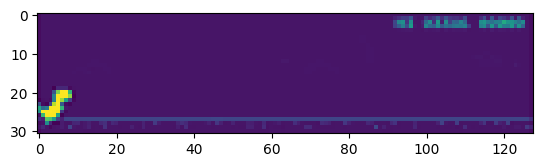

In [4]:
def find_dino_sprite(frame, dino_sprite):
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  template_gray = cv2.cvtColor(dino_sprite, cv2.COLOR_BGR2GRAY)
  result = cv2.matchTemplate(frame_gray, template_gray, cv2.TM_CCOEFF_NORMED)
  threshold = 0.8
  loc = np.where(result >= threshold)
  if len(loc[0]) == 0:
      return None
  top_left = (loc[1][0], loc[0][0])
  bottom_right = (top_left[0] + dino_sprite.shape[1], top_left[1] + dino_sprite.shape[0])
  return (top_left, bottom_right)


if not os.path.exists("processed_video.npy"):
  # Crop only the required part of the frame
  # with Dino as the reference
  dino_sprite = cv2.imread("dino.jpg")
  frames = []
  while True:
    ret, frame = video.read()
    videoH, videoW, _ = frame.shape
    place = find_dino_sprite(frame, dino_sprite)
    y1, y2 = place[0][1], place[1][1]
    x1, x2 = place[0][0], place[1][0]
    dino_height = y2-y1
    y1 = max(y1-int(dino_height * 2), 0)
    y2 = min(y2 + int(dino_height * 0.2), videoH)
    x1, x2 = x1, videoW
    break


  pb = tqdm(total=no_frames)
  frame_number = 0
  frames = []

  while True:
    ret, frame = video.read()
    if not ret:
          break

    # Cropping the Image
    cropped_frame = frame[y1:y2, x1:x2]

    # Convert Image to Grayscale
    gray_image = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)

    # Normalize the image
    gray_float = gray_image.astype(np.float32)
    mean = np.mean(gray_float)
    std = np.std(gray_float)
    normalized_image = (gray_float - mean) / std

    # Scaling the image
    scale = 0.2
    # width = int(cropped_frame.shape[1] * scale)
    # height = int(cropped_frame.shape[0] * scale)
    resized_frame = cv2.resize(normalized_image, (128, 31),
                                interpolation=cv2.INTER_AREA)
    frames.append(resized_frame)
    pb.update(1)
  np.save("processed_video", frames)
else:
  # Load from file if Processing is already done
  frames = np.load("processed_video.npy")

frames = np.array(frames)
print(frames.shape)
plt.imshow(frames[0])

# Load Key Hit Data Corresponding to frames

In [5]:
with open("keydata.txt", "r") as f:
  times = [float(x.strip()) for x in f.readlines()]

no_frames = frames.shape[0]
ratio = no_frames/times[-1]
# Here -2 to keep a small buffer after hitting key
descrete_times = [min(int(ratio*t)-2, no_frames-1) for t in times]
waves = np.zeros(no_frames, dtype='float64')
waves[descrete_times] = 1

print("Average Frames per Click:", np.mean(np.diff(descrete_times)))
print("No. of hits:", int(sum(waves)))
waves[515:530]

Average Frames per Click: 30.749295774647887
No. of hits: 356


array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Custom Data Loader for balanced Training 0s and 1s

In [6]:
train_frames, train_waves = frames[:int(0.8*len(frames))], waves[:int(0.8*len(frames))]
test_frames, test_waves = frames[int(0.8*len(frames)):], waves[int(0.8*len(frames)):]


def get_datapoints(indices):
  for index in indices:
    assert(index >= 8)
  inputs = []
  for index in indices:
    inputs.append(frames[index-8:index])
  return np.array(inputs), waves[indices]

def get_batch_data(batch_size, test=False):
  if not test:
    target_frames = train_frames
    target_waves = train_waves
  else:
    target_frames = test_frames
    target_waves = test_waves
  # For balancing 0s and 1s data (30% ones and 70% zeros)
  no_of_ones = int(0.3*batch_size)
  no_of_zeros = int(batch_size - no_of_ones)
  index_of_ones = np.nonzero(waves == 1.0)[0]
  index_of_ones = index_of_ones[index_of_ones >= 28]
  index_of_zeros = np.nonzero(waves == 0.0)[0]
  index_of_zeros = index_of_zeros[index_of_zeros >= 28]
  required_ones = np.random.choice(index_of_ones, size=no_of_ones, replace=False)
  required_zeros = np.random.choice(index_of_zeros, size=no_of_zeros, replace=False)
  X1, y1 = get_datapoints(required_ones)
  X0, y0 = get_datapoints(required_zeros)
  X, y = np.concatenate((X0, X1), axis=0), np.concatenate((y0, y1), axis=0)
  zipped = list(zip(X, y))
  random.shuffle(zipped)
  X, y = zip(*zipped)
  X, y = np.array(X), np.array(y)
  return X, y

X, y = get_batch_data(32)
X.shape, y.shape

((32, 8, 31, 128), (32,))

# Create a model for Training

In [7]:
model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(8, 31, 128)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 31, 64)         73792     
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 15, 64)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 4, 15, 64)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 15, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 7, 128)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 2, 7, 128)         0

2024-04-09 22:51:24.748534: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Train The model

In [8]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []

def train_and_validate_model(model, epochs=10, batch_size=32, steps_per_epoch=100, validation_steps=10):
    for epoch in range(epochs):
        train_loss = 0
        train_accuracy = 0
        # Training loop
        for step in tqdm(range(steps_per_epoch)):
            X_batch, y_batch = get_batch_data(batch_size)
            loss, accuracy = model.train_on_batch(X_batch, y_batch)
            train_loss += loss
            train_accuracy += accuracy
        train_loss /= steps_per_epoch
        train_accuracy /= steps_per_epoch
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)

        # Validation loop
        val_loss = 0
        val_accuracy = 0
        for step in range(validation_steps):
            X_batch, y_batch = get_batch_data(batch_size, test=True)
            loss, accuracy = model.evaluate(X_batch, y_batch, verbose=0)
            val_loss += loss
            val_accuracy += accuracy
        val_loss /= validation_steps
        val_accuracy /= validation_steps
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f},Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

train_and_validate_model(model, epochs=50, batch_size=32, steps_per_epoch=120, validation_steps=20)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/50, Loss: 0.6525,Accuracy: 0.6914, Val Loss: 0.5998, Val Accuracy: 0.7188


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2/50, Loss: 0.6034,Accuracy: 0.7188, Val Loss: 0.5942, Val Accuracy: 0.7188


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3/50, Loss: 0.5933,Accuracy: 0.7169, Val Loss: 0.5894, Val Accuracy: 0.7188


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4/50, Loss: 0.5872,Accuracy: 0.7159, Val Loss: 0.5739, Val Accuracy: 0.7188


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5/50, Loss: 0.5795,Accuracy: 0.7172, Val Loss: 0.5746, Val Accuracy: 0.7188


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6/50, Loss: 0.5737,Accuracy: 0.7201, Val Loss: 0.5750, Val Accuracy: 0.7188


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7/50, Loss: 0.5572,Accuracy: 0.7195, Val Loss: 0.5348, Val Accuracy: 0.7219


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8/50, Loss: 0.5373,Accuracy: 0.7284, Val Loss: 0.4982, Val Accuracy: 0.7359


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9/50, Loss: 0.5284,Accuracy: 0.7221, Val Loss: 0.4869, Val Accuracy: 0.7672


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10/50, Loss: 0.5001,Accuracy: 0.7477, Val Loss: 0.4639, Val Accuracy: 0.7625


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 11/50, Loss: 0.4771,Accuracy: 0.7518, Val Loss: 0.4273, Val Accuracy: 0.8047


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 12/50, Loss: 0.4559,Accuracy: 0.7721, Val Loss: 0.4095, Val Accuracy: 0.8141


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 13/50, Loss: 0.4273,Accuracy: 0.7836, Val Loss: 0.3514, Val Accuracy: 0.8547


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 14/50, Loss: 0.4039,Accuracy: 0.8044, Val Loss: 0.3305, Val Accuracy: 0.8391


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 15/50, Loss: 0.3877,Accuracy: 0.8177, Val Loss: 0.3444, Val Accuracy: 0.8422


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 16/50, Loss: 0.3498,Accuracy: 0.8352, Val Loss: 0.2481, Val Accuracy: 0.8953


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 17/50, Loss: 0.3281,Accuracy: 0.8438, Val Loss: 0.2616, Val Accuracy: 0.8875


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 18/50, Loss: 0.3167,Accuracy: 0.8529, Val Loss: 0.2112, Val Accuracy: 0.9328


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 19/50, Loss: 0.2775,Accuracy: 0.8729, Val Loss: 0.1938, Val Accuracy: 0.9250


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 20/50, Loss: 0.2672,Accuracy: 0.8849, Val Loss: 0.2087, Val Accuracy: 0.9172


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 21/50, Loss: 0.2643,Accuracy: 0.8846, Val Loss: 0.2008, Val Accuracy: 0.9187


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 22/50, Loss: 0.2444,Accuracy: 0.8958, Val Loss: 0.1601, Val Accuracy: 0.9578


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 23/50, Loss: 0.2235,Accuracy: 0.9039, Val Loss: 0.1440, Val Accuracy: 0.9578


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 24/50, Loss: 0.2269,Accuracy: 0.9021, Val Loss: 0.1447, Val Accuracy: 0.9469


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 25/50, Loss: 0.2153,Accuracy: 0.9133, Val Loss: 0.1134, Val Accuracy: 0.9719


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 26/50, Loss: 0.1816,Accuracy: 0.9242, Val Loss: 0.1127, Val Accuracy: 0.9531


  0%|          | 0/120 [00:00<?, ?it/s]

# Check the Train/Test Stats

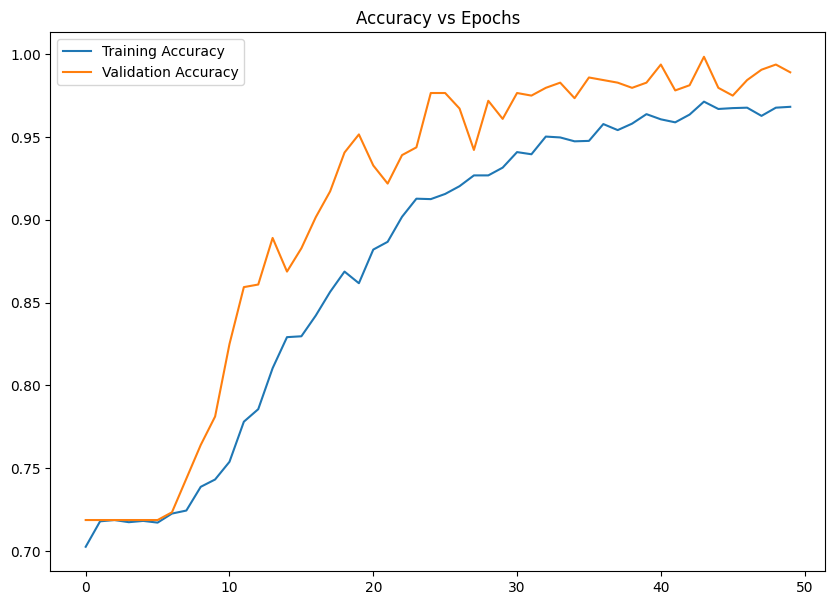

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Accuracy vs Epochs")
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()

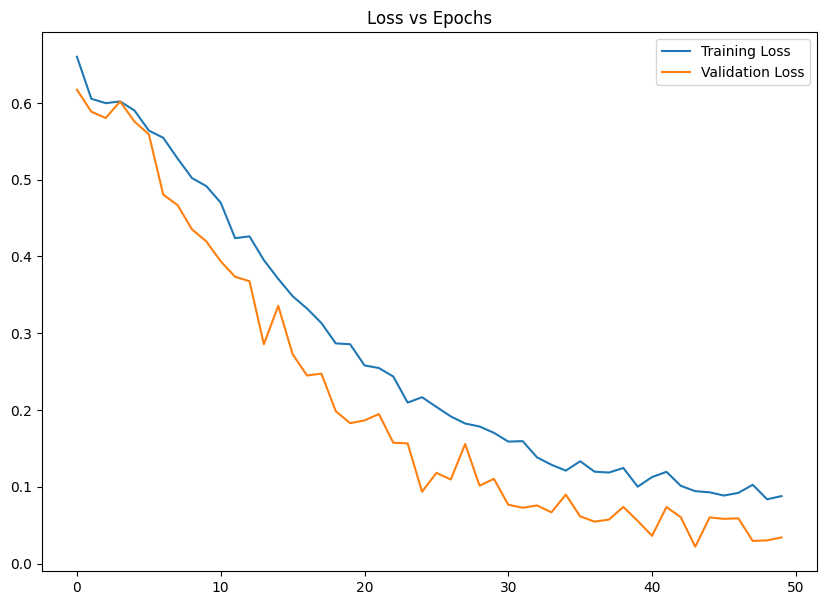

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Loss vs Epochs")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()

# Save the Model

In [ ]:
model.save("dino.keras")

In [ ]:

import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0
